# Dependencies


In [3]:
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 2.1 MB/s eta 0:00:00


# Packages and plot functions

In [4]:
%matplotlib inline
import itertools

import pandas as pd
import numpy as np
from datetime import date

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from hmmlearn import hmm
import yfinance as yf

In [5]:
np.random.seed(42)

plot_params = {'legend.fontsize': 20,
               'figure.figsize': (10, 8),
               'axes.labelsize':  15,
               'axes.titlesize':  20,
               'xtick.labelsize': 15,
               'ytick.labelsize': 15,
               'figure.dpi': 300}

plt.style.use('seaborn-v0_8')

plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

colors = [color_dark_blue, color_light_blue, purple]

color_line = list(itertools.product(['-', ':', '--', ':' '-', ':'], colors))

# Data Gathering


In [6]:
ticker = ['SPY']
df = yf.download(ticker)

[*********************100%%**********************]  1 of 1 completed


In [7]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.840687,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.017353,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.070358,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.335377,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.441380,531500
...,...,...,...,...,...,...
2024-02-27,506.700012,507.160004,504.750000,506.929993,506.929993,48854500
2024-02-28,505.329987,506.859985,504.959991,506.260010,506.260010,56506600
2024-02-29,508.070007,509.739990,505.350006,508.079987,508.079987,83924800


In [8]:
df['Log'] = np.log(df['Close'])
df['Returns'] = df['Log'].diff()
df['Range'] = (df['High'] / df['Low']) - 1
df.dropna(inplace=True)
data = df[['Returns']]

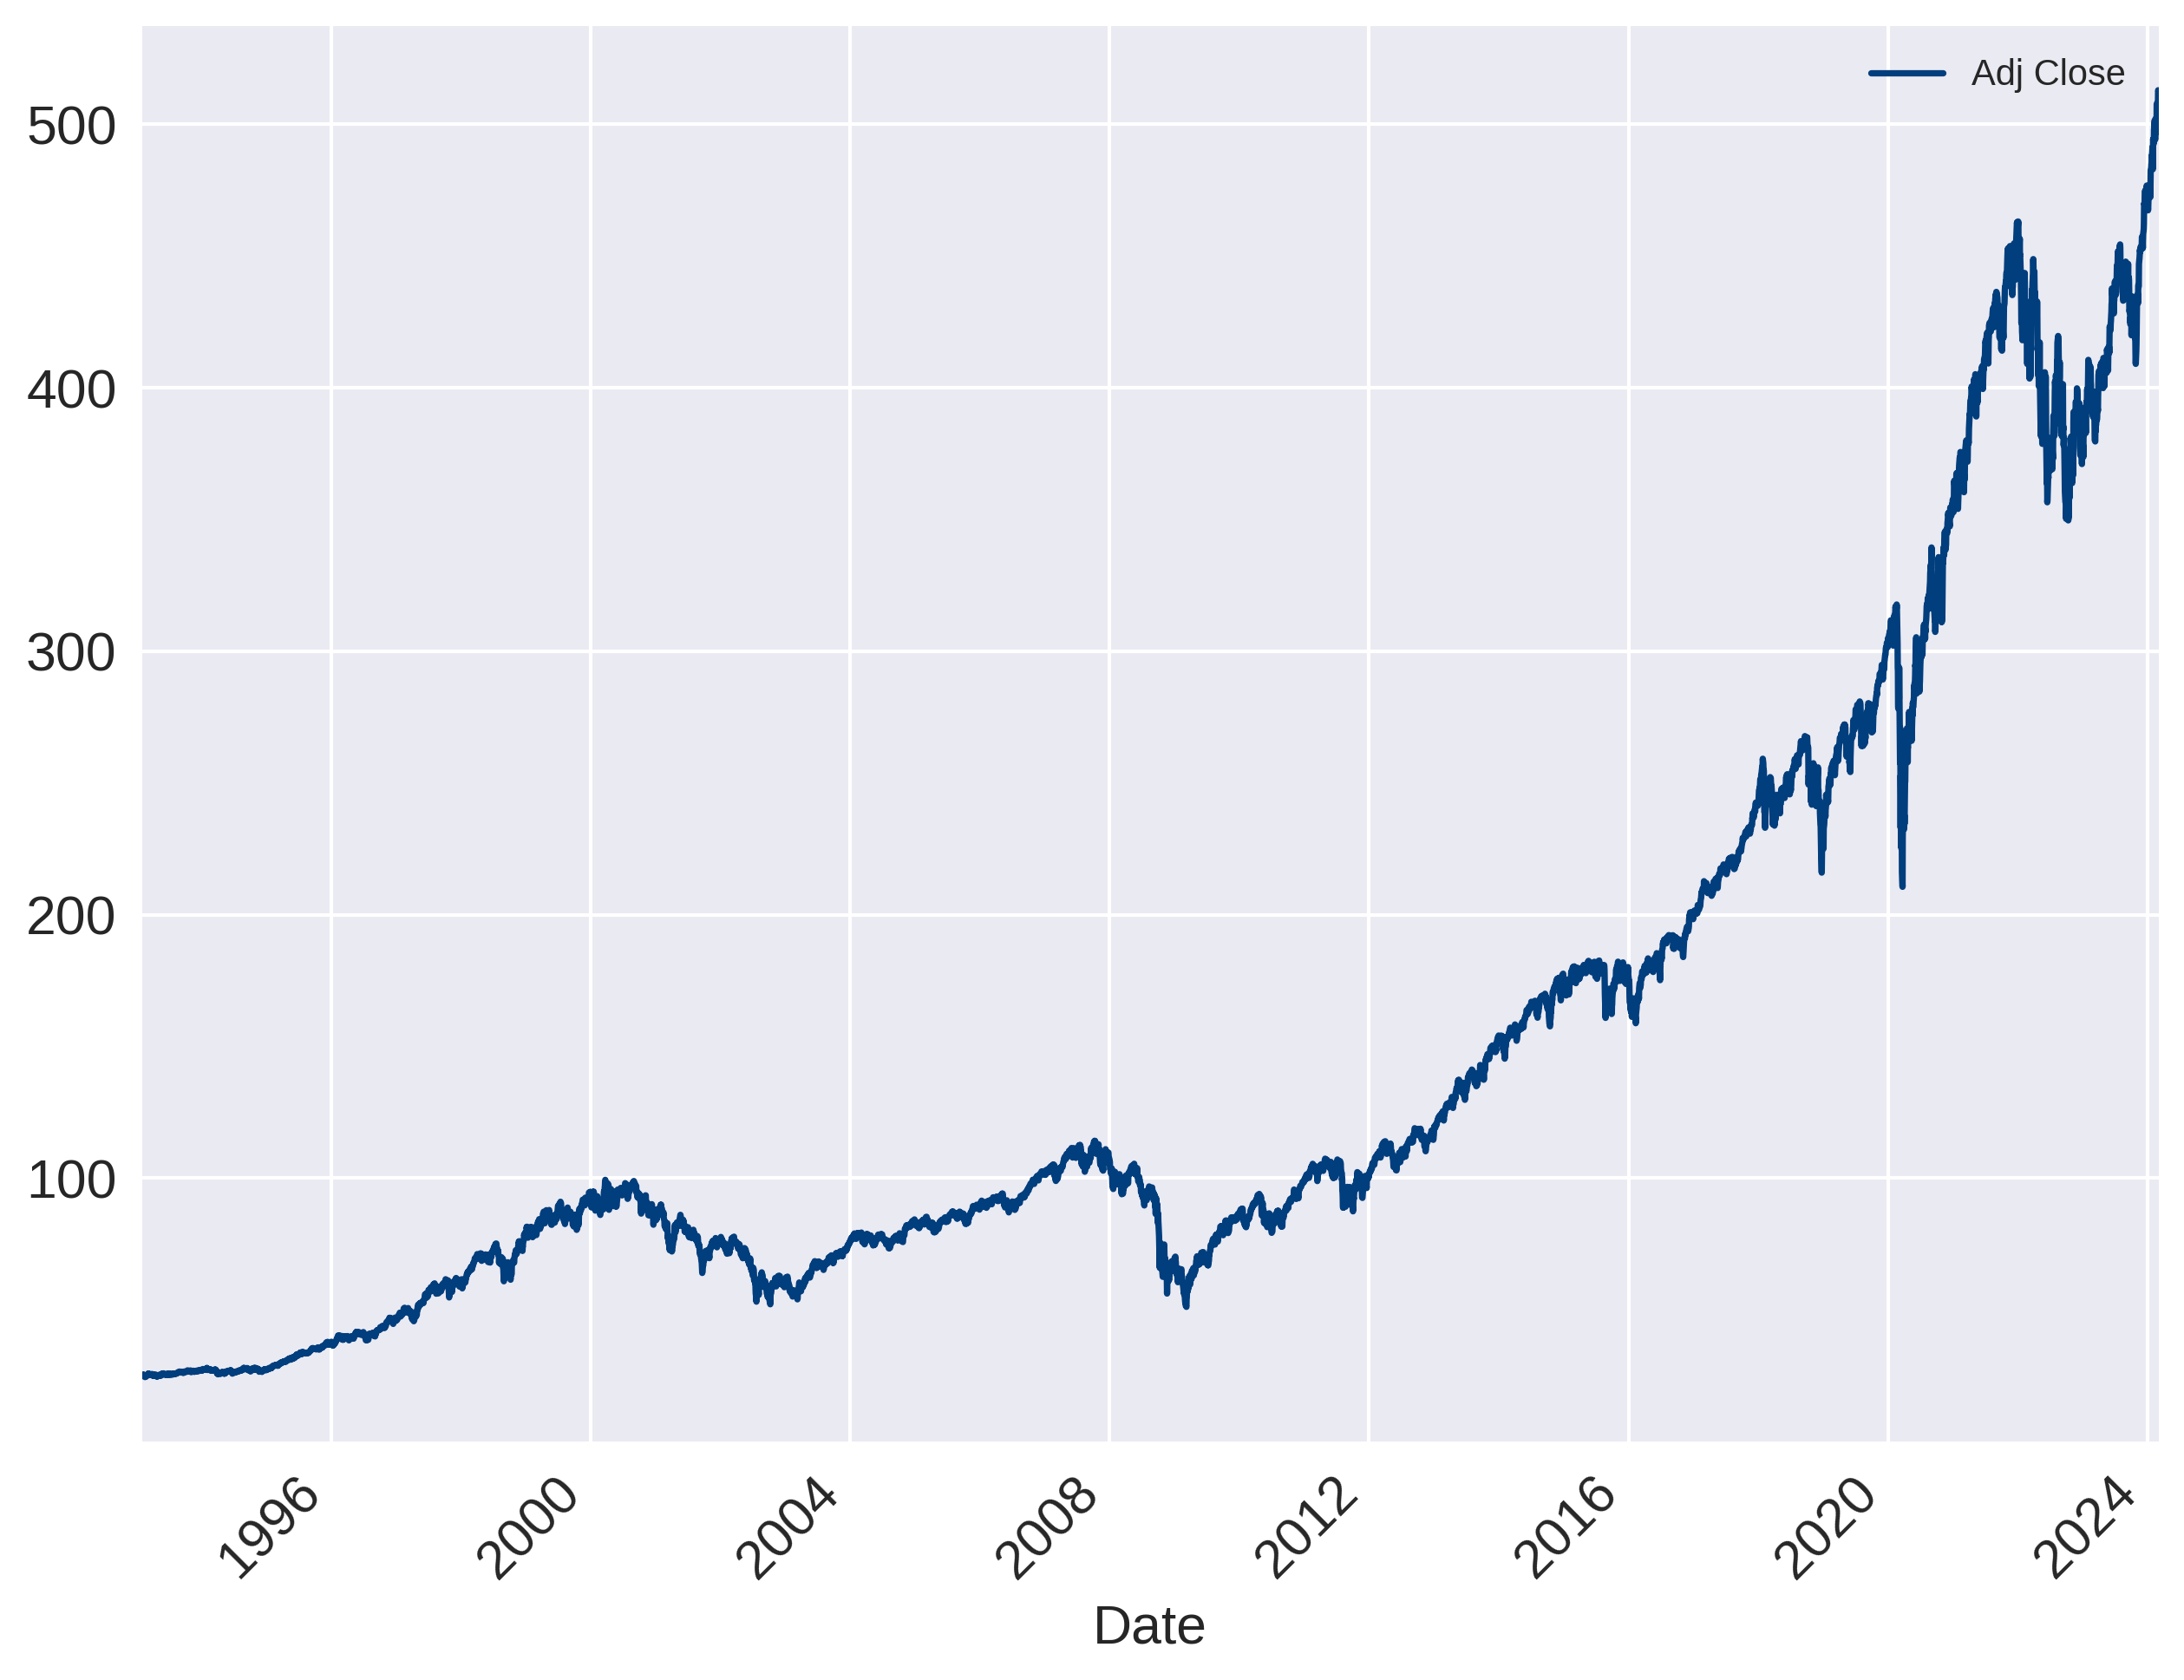

In [9]:
df['Adj Close'].plot(color=color_line[0][1], linestyle=color_line[0][0])
plt.legend(fontsize="10")
plt.xticks(rotation=45, ha='right')
plt.xlim([df.index[0], df.index[-1]]);

# Model Fitting

In [10]:
scores = list()
models = list()
for n_components in range(1, 4):
    for idx in range(10):  # ten different random starting states
        # define our hidden Markov model
        model = hmm.GaussianHMM(n_components=n_components, random_state=idx,
                               n_iter=10)
        model.fit(data)
        models.append(model)
        scores.append(model.score(data))
        print(f'Converged: {model.monitor_.converged}\t\t'
              f'Score: {scores[-1]}')

# get the best model
model = models[np.argmax(scores)]
print(f'The best model had a score of {max(scores)} and '
      f'{model.n_components} components')

# use the Viterbi algorithm to predict the most likely sequence of states
# given the model
states = model.predict(data)

Converged: True		Score: 23621.365659810588
Converged: True		Score: 23621.365659810588
Converged: True		Score: 23621.365659810588
Converged: True		Score: 23621.365659810588
Converged: True		Score: 23621.365659810588
Converged: True		Score: 23621.365659810588
Converged: True		Score: 23621.365659810588
Converged: True		Score: 23621.365659810588
Converged: True		Score: 23621.365659810588
Converged: True		Score: 23621.365659810588
Converged: True		Score: 24457.37402386904
Converged: True		Score: 24622.932230158473
Converged: True		Score: 24368.21572288095
Converged: True		Score: 25107.115341959754
Converged: True		Score: 25032.38983965037
Converged: True		Score: 24297.607420886907
Converged: True		Score: 24596.78927151757
Converged: True		Score: 24241.52134995049
Converged: True		Score: 24678.28166762634
Converged: True		Score: 25116.428916882574
Converged: True		Score: 24233.202782796543
Converged: True		Score: 24996.51750332334
Converged: True		Score: 24313.466866208815
Converged: True		S

In [11]:
model = hmm.GaussianHMM(n_components=n_components, random_state=idx, n_iter=10)
model.fit(data)
states = model.predict(data)

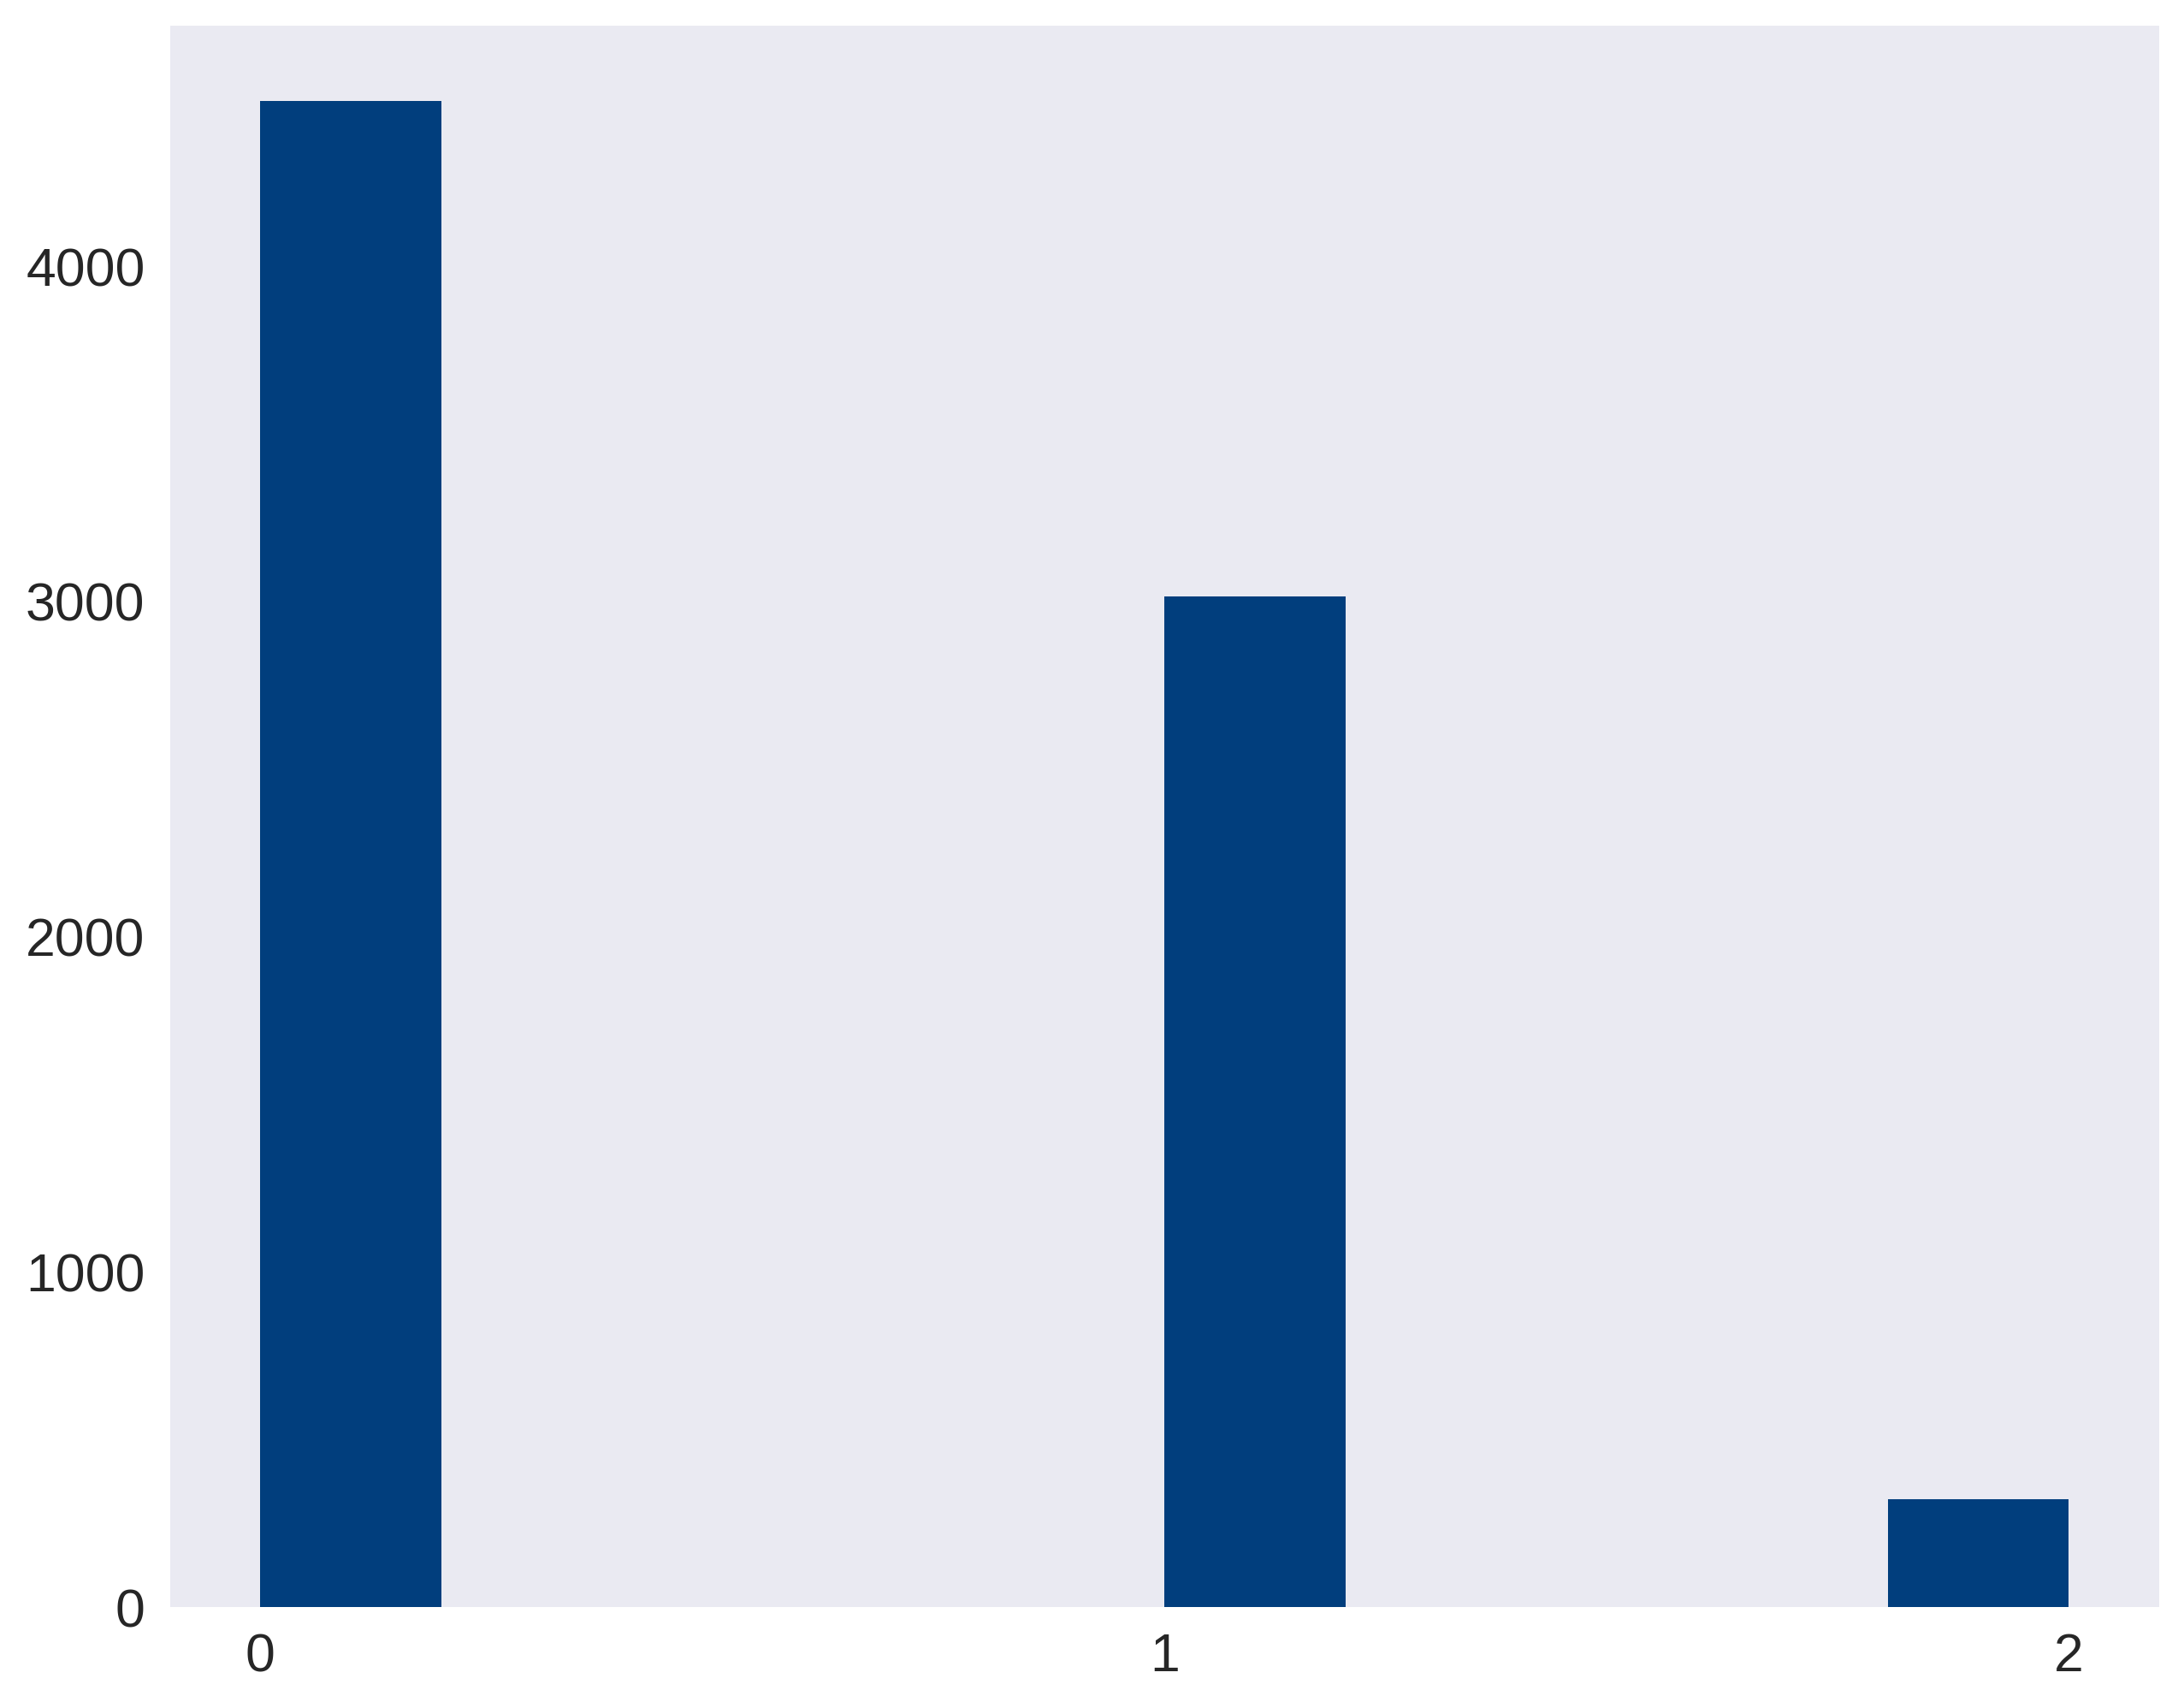

In [12]:
fig, ax = plt.subplots()
pd.Series(states).hist(color=color_line[0][1], align='mid')
ax.grid(False)
ax.set_xticks(np.arange(n_components));

In [13]:
model.transmat_

array([[9.86785179e-01, 1.09196707e-02, 2.29515074e-03],
       [1.94044209e-02, 9.60817965e-01, 1.97776141e-02],
       [2.73102067e-04, 1.57977756e-01, 8.41749142e-01]])

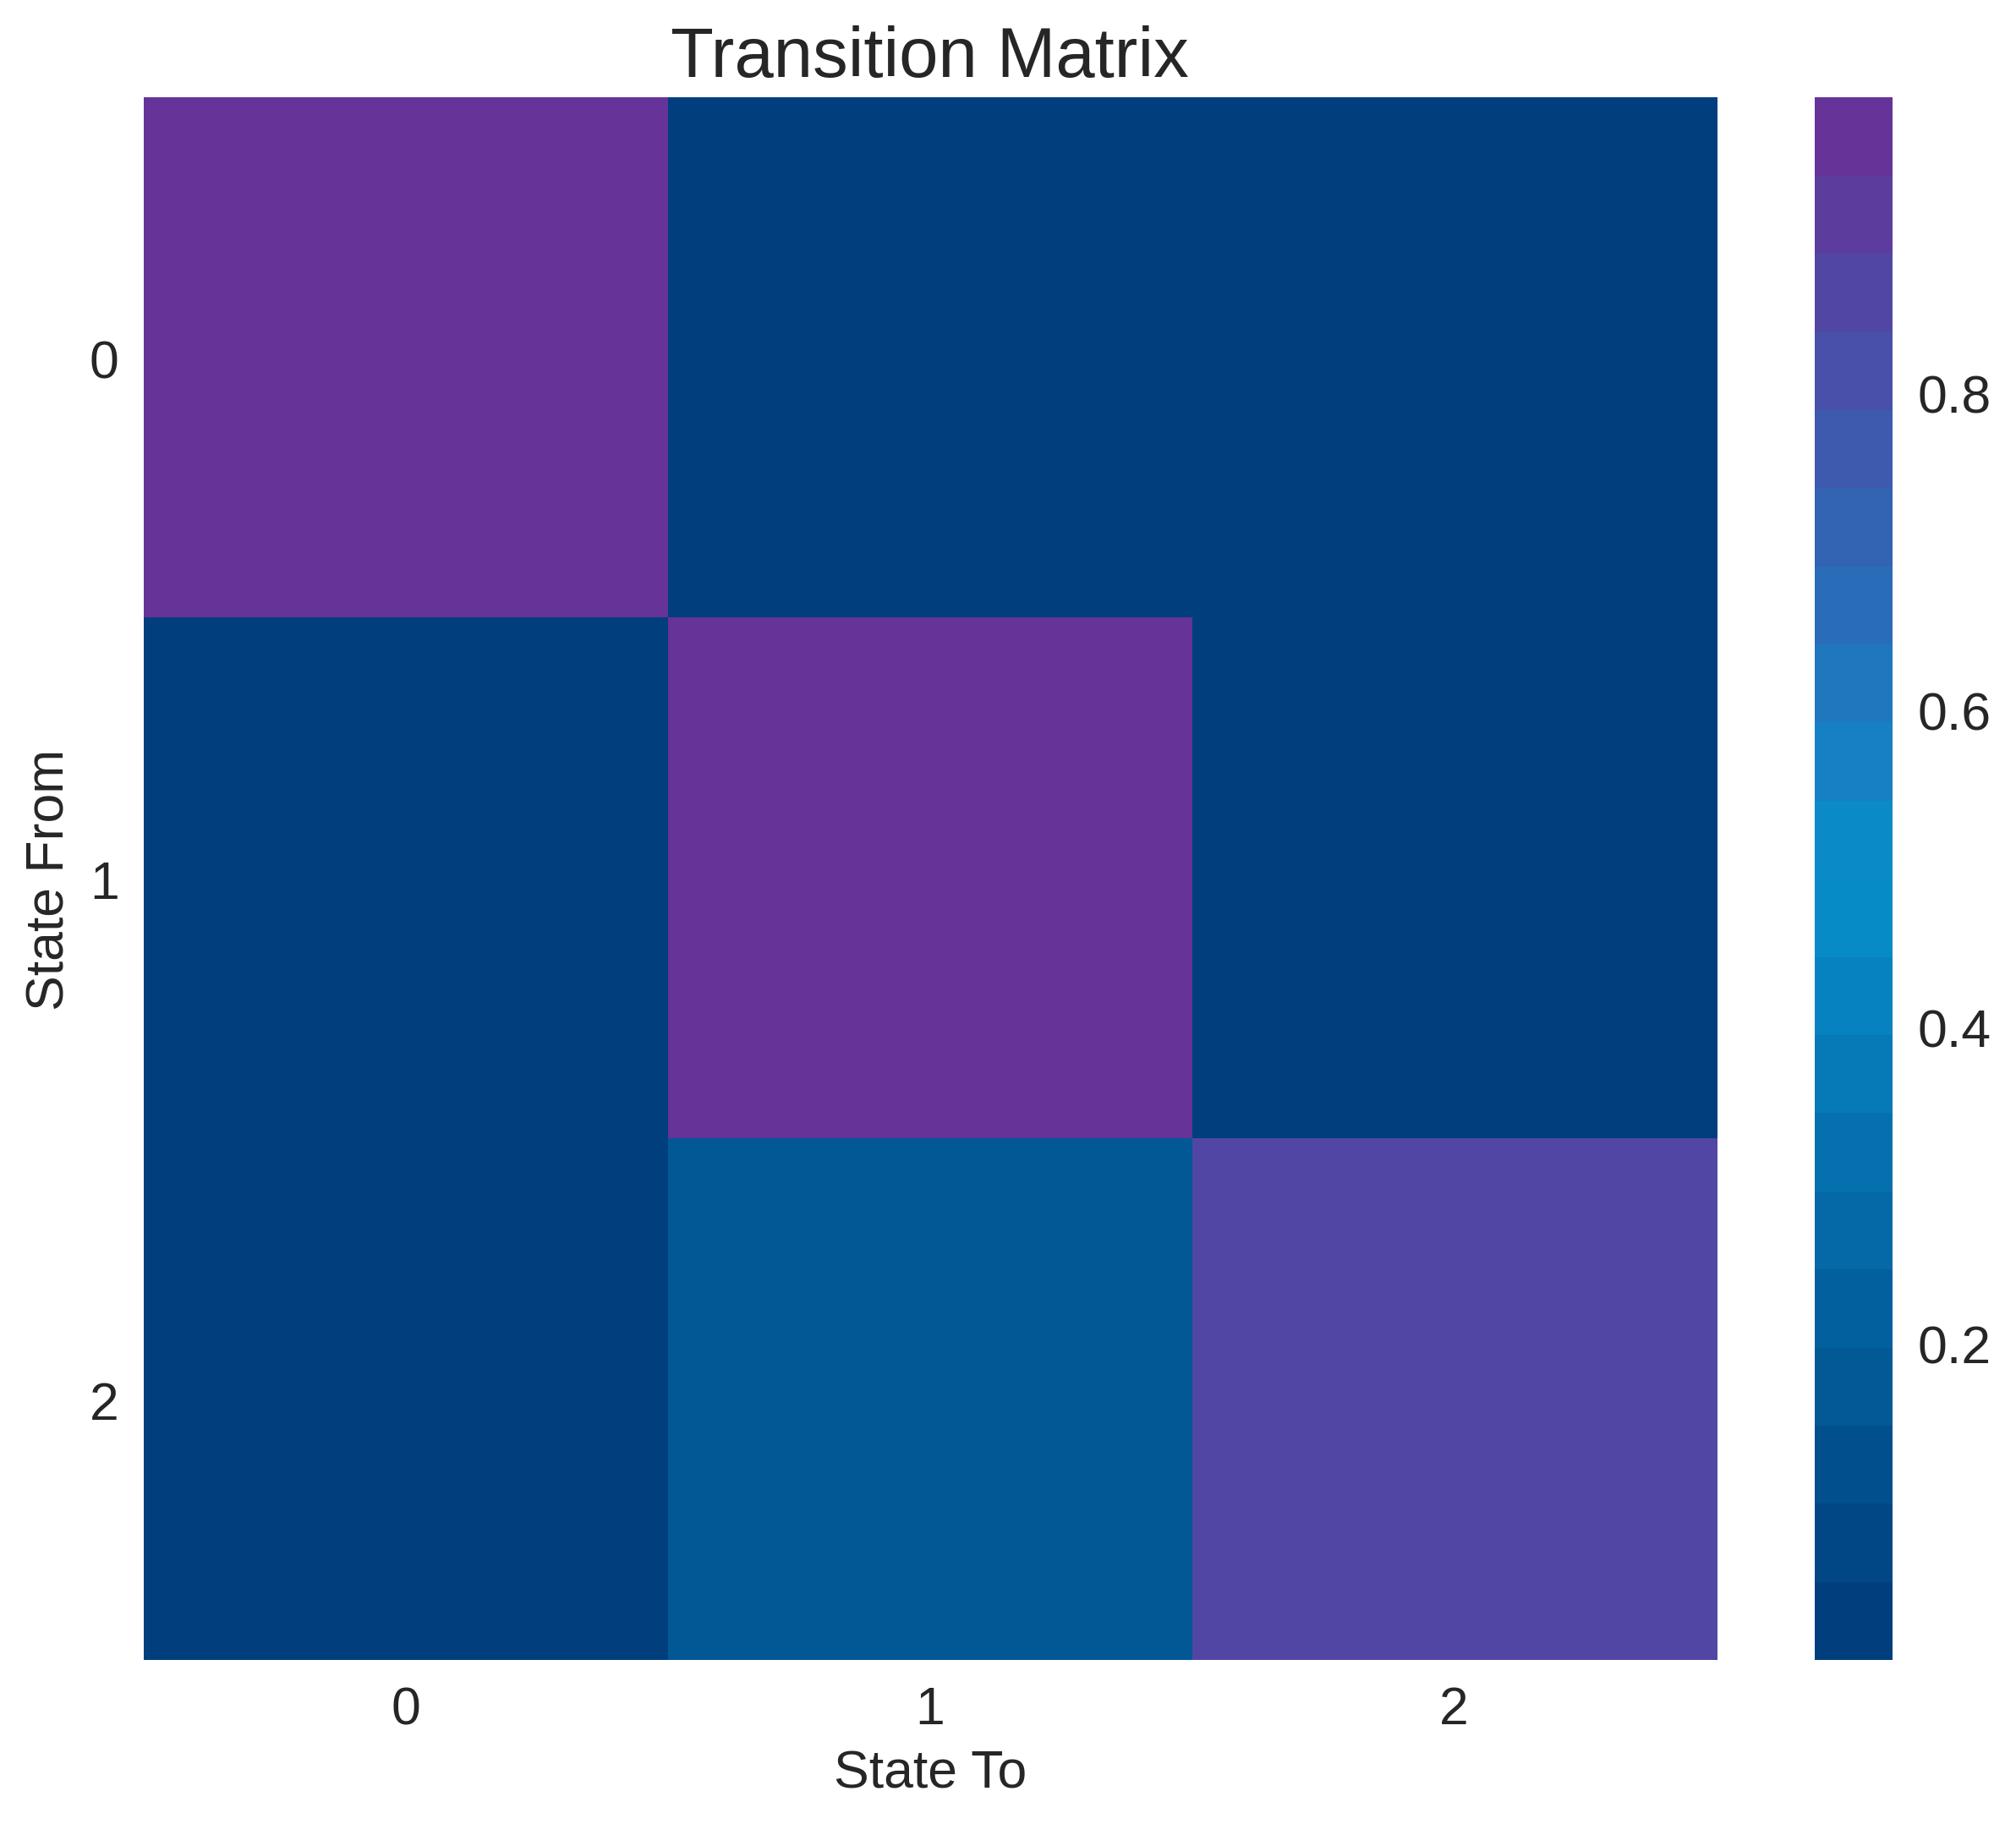

In [14]:
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=20)

fig, ax = plt.subplots()
plot = ax.imshow(model.transmat_, aspect='auto', cmap=cmap)
ax.grid(False)
plt.colorbar(plot, ax=ax)
ax.set_title('Transition Matrix')
ax.set_xlabel('State To')
ax.set_ylabel('State From')
ax.set_xticks(np.arange(n_components))
ax.set_yticks(np.arange(n_components));

In [15]:
df_state = pd.DataFrame(columns=['Date', 'Adj Close', 'Color'])
df_state['Date'] = df.index
df_state['Adj Close'] = df['Adj Close'].values


i = 0
for state in states:
    df_state.iloc[i,2] = state
    i += 1

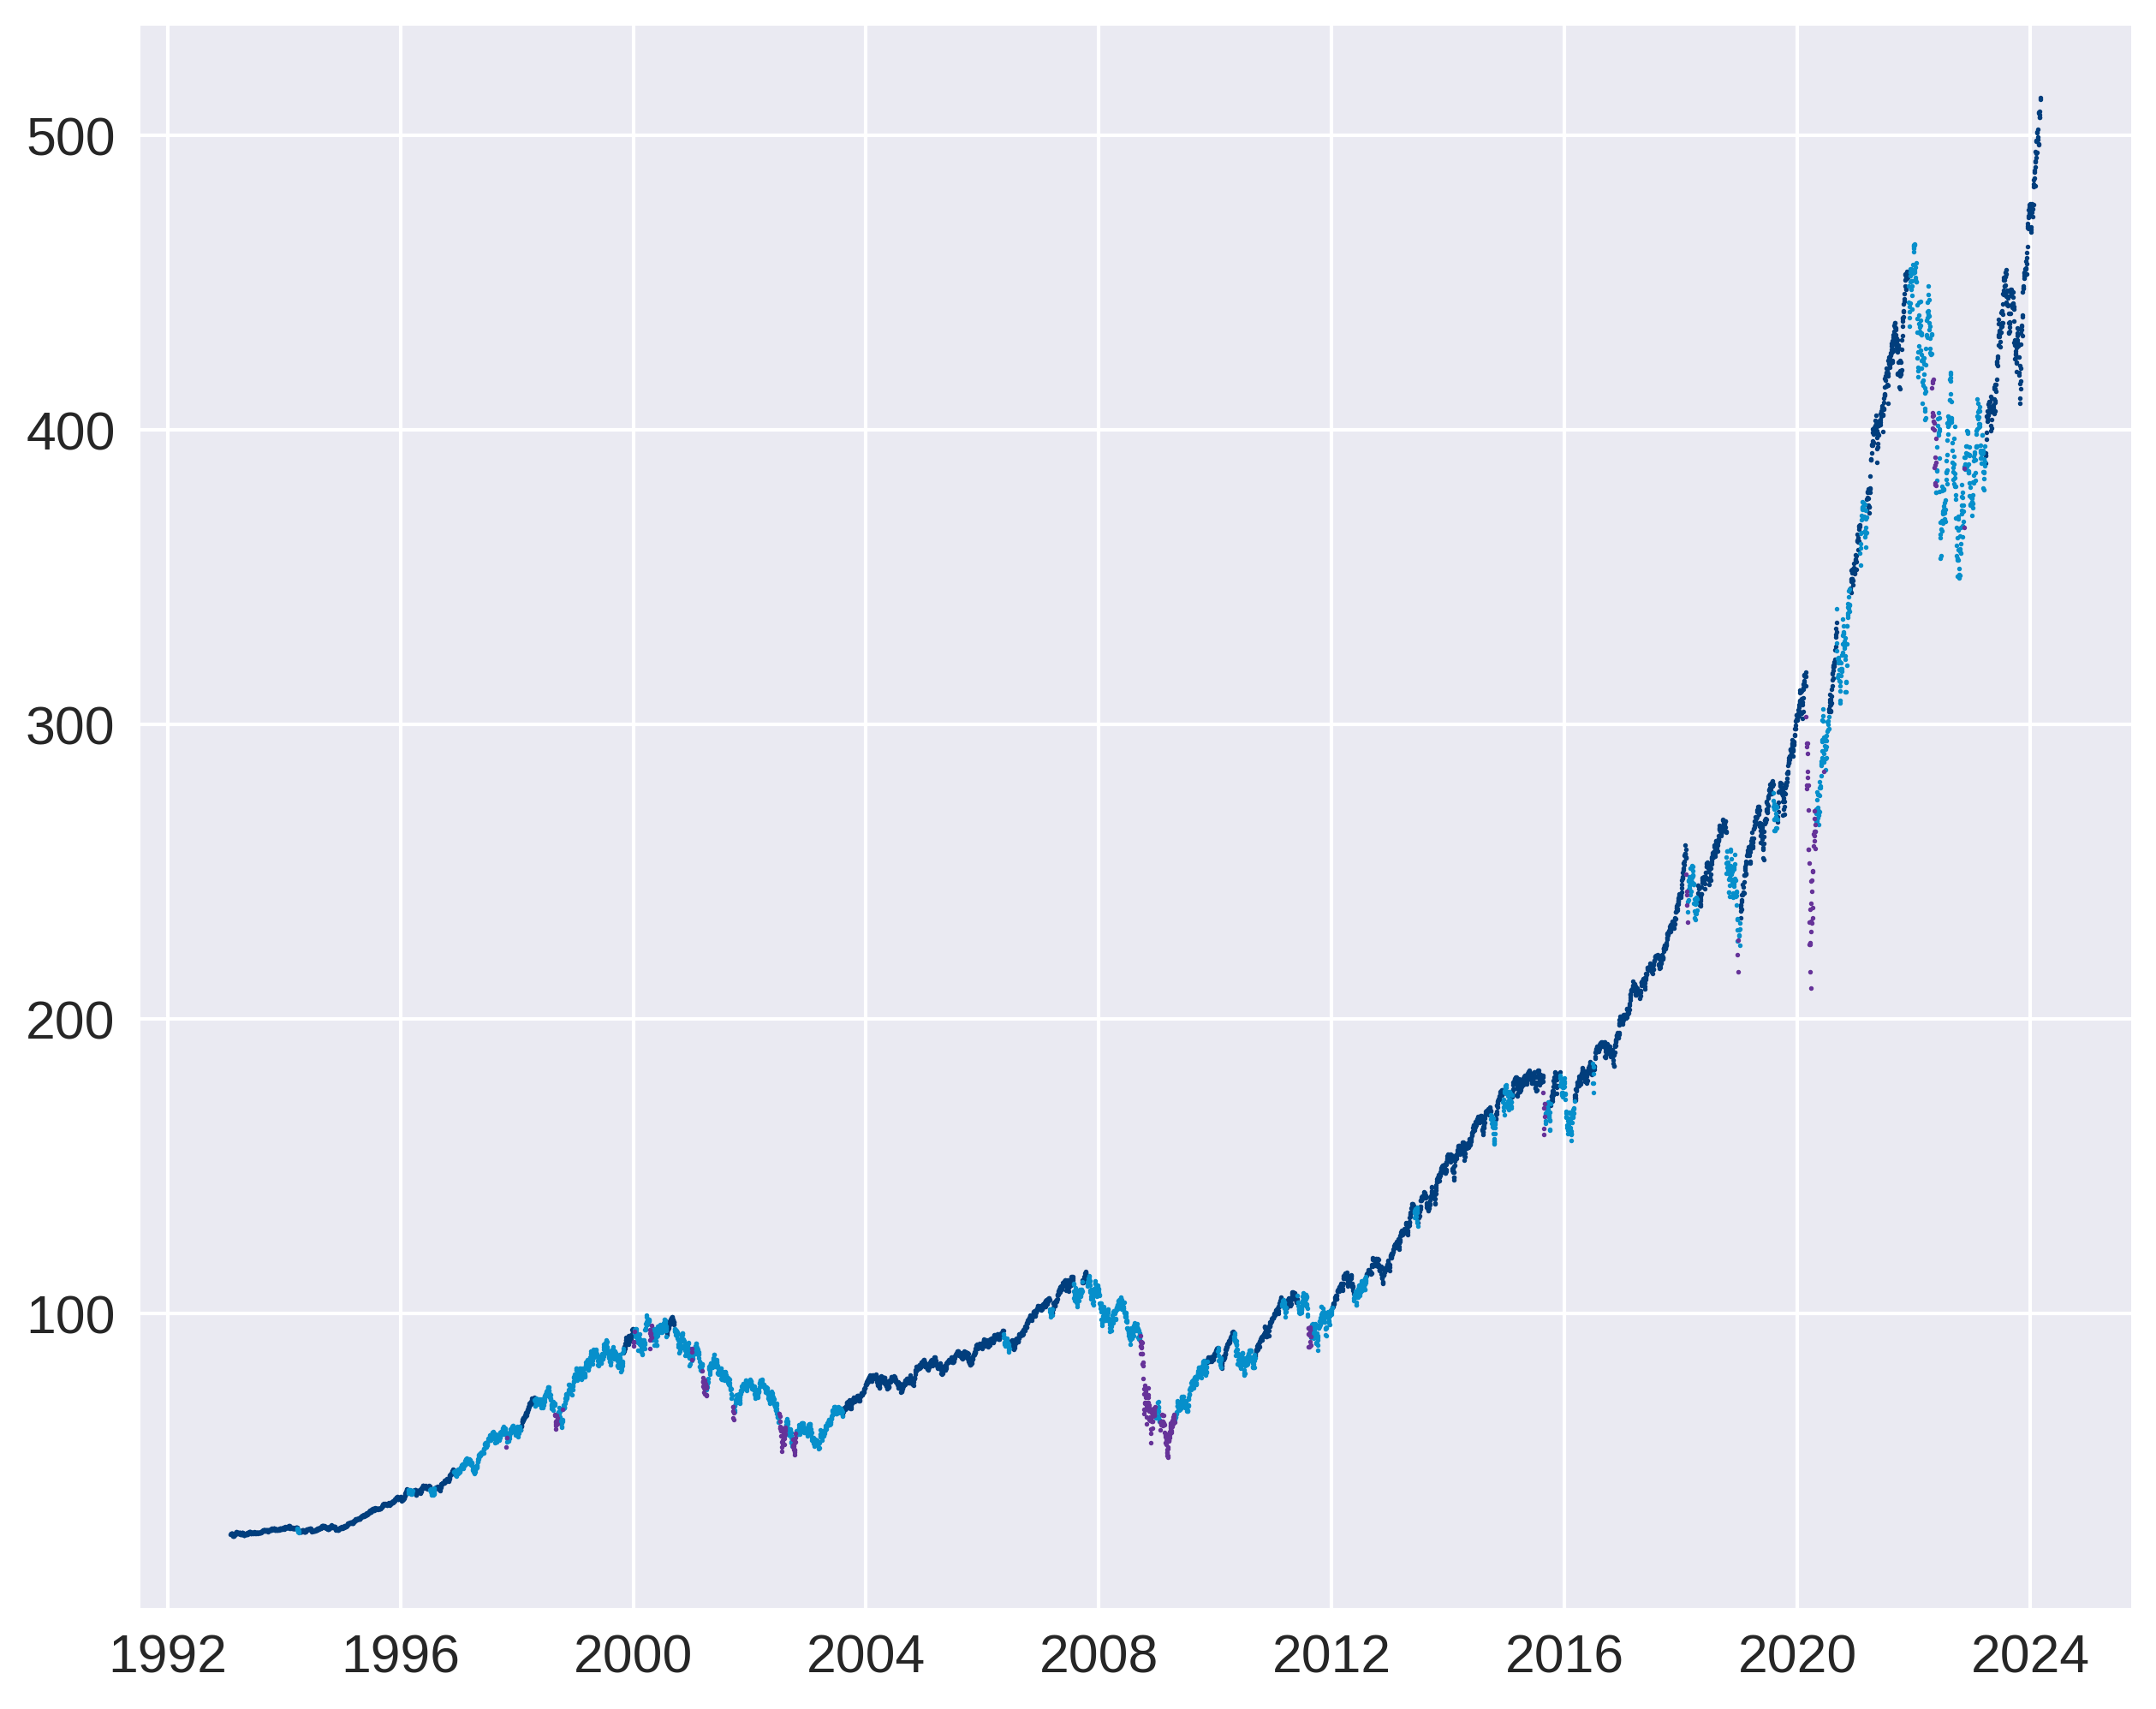

In [16]:
colors = [color_dark_blue, color_light_blue, purple, 'blue']

for state in range(n_components):
    plt.scatter(df_state[df_state['Color'] == state]['Date'], df_state[df_state['Color'] == state]['Adj Close'], color=colors[state], s=1)